# <font color='#922B21'><center> DIABATES PREDICTION  </center> </font> 

## <font color='#7D3C98'>Table of Contents</font>

1. [Objective](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Loading Data and Pre-processing](#4)
5. [Build, compile and train a model](#5)
6. [Hyperparameter Tunnig](#6)
7. [Making predictions](#7)

<a name="1"></a>
## <font color='red'>  1. Objective </font> 

Predict based on diagnostic measurements whether a patient has diabetes.

<a name="2"></a>
## <font color='red'>  2. Modules </font> 

In [92]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

import keras_tuner


<a name="3"></a>
## <font color='red'>  3. Helper Functions </font> 

In [3]:
# confussion matrix
def plot_confusion_matrix(y_test,y_pred,labels,figsize=(8,6)):
    plt.figure(figsize=figsize)
    confusion_mtx = tf.math.confusion_matrix(y_test,y_pred)
    sns.heatmap(confusion_mtx,
                xticklabels=labels,
                yticklabels=labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    
    

# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Plot for Binary Crossentropy
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary Crossentropy')
    axs[0].plot(hist['epoch'], hist['loss'], label='Train Error')
    axs[0].plot(hist['epoch'], hist['val_loss'], label='Val Error')
    axs[0].legend()

    # Plot for Accuracy
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    axs[1].plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    axs[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

<a name="4"></a>
## <font color='red'> 4. Loading data and pre-processing </font>

### Loading and exploring data

In [4]:
!cd data && ls

diabetes.csv


In [5]:
df = pd.read_csv('data/diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

We have no categorical values.

### Pre-processing

In [8]:
# separate features from labels
X = df.copy()
y = X.pop('Outcome')

In [9]:
# train/tets split; stratify - make sure classes are evenlly represented across splits
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.75)

In [10]:
# scaling numerical features

# Create a StandardScaler object
scaler = StandardScaler()

# Apply
X_train = scaler.fit_transform(X_train) # fit and transform
X_test = scaler.transform(X_test) # only transform

In [11]:
# input shape
input_shape = X_train[1].shape
input_shape

(8,)

<a name="5"></a>
## <font color='red'> 5. Build, compile and train a model </font> 

In [131]:
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(32,activation='relu',input_shape=input_shape),
        layers.Dropout(0.1),
        layers.Dense(32,activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1,activation='sigmoid'), # 2 classes
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [132]:
model = build_model(input_shape)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                288       
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1377 (5.38 KB)
Trainable params: 1377 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
# training

early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )


history = model.fit(
    X_train,y_train,
    validation_split=0.2,
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0
)

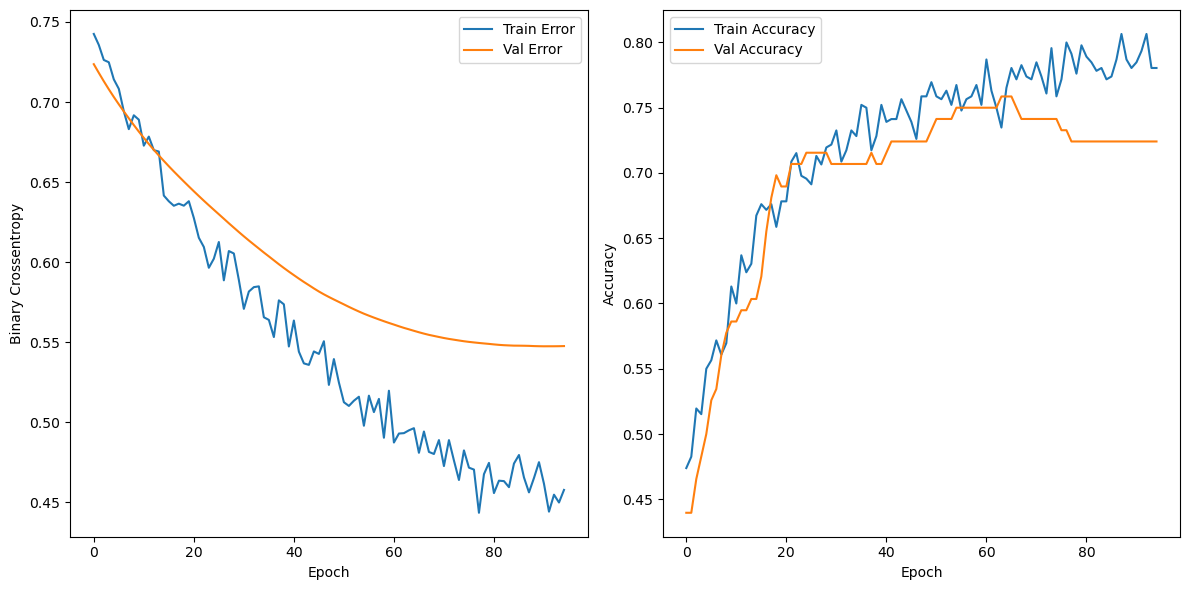

In [134]:
plot_history(history)

6/6 [==============================] - 0s 1ms/step


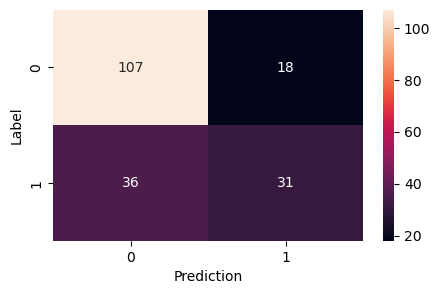

In [135]:
# confussion matrix

y_preds = model.predict(X_test)

confusion_mtx = plot_confusion_matrix(y_test, tf.round(y_preds),['0','1'],(5,3))

In [136]:
scores = model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.5201 - accuracy: 0.7188


<a name="6"></a>
## <font color='red'>  6. Hyperparameter tuning </font> 

In [137]:
def build_model(hp, input_shape):
    model = keras.Sequential([
        layers.Dense(hp.Choice('units1', [16, 32, 64]),activation='relu',input_shape=input_shape),
        layers.Dropout(hp.Choice('dropout_rate1',[0.2, 0.5])),
        layers.Dense(hp.Choice('units2', [10, 32, 64]),activation='relu'),
        layers.Dropout(hp.Choice('dropout_rate2',[0.2, 0.5])),
        layers.Dense(1,activation='sigmoid'), # 2 classes        
    ])
                     
    lr = hp.Choice("learning_rate",values=[1e-2, 1e-3])
    opt = keras.optimizers.Adam(learning_rate=lr)
    # compile the model
    model.compile(optimizer=opt, loss="binary_crossentropy",
        metrics=["accuracy"])
                     
    return model

In [138]:
tuner = keras_tuner.RandomSearch(
    lambda hp:build_model(hp, input_shape),
    objective='val_loss',
    max_trials=15)

In [139]:
tuner.search(X_train, y_train, epochs=50,validation_split=0.2)

Trial 15 Complete [00h 00m 04s]
val_loss: 0.5139523148536682

Best val_loss So Far: 0.48935186862945557
Total elapsed time: 00h 01m 03s
INFO:tensorflow:Oracle triggered exit


In [140]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.2
units2: 32
dropout_rate2: 0.2
learning_rate: 0.01
Score: 0.48935186862945557


In [141]:
# re-training with the best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)



early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )


final_history = final_model.fit(
                            X_train, y_train, 
                            epochs=200,
                            validation_split=0.2,
                            batch_size=512,
                            callbacks=[early_stopping],
                            verbose=0)

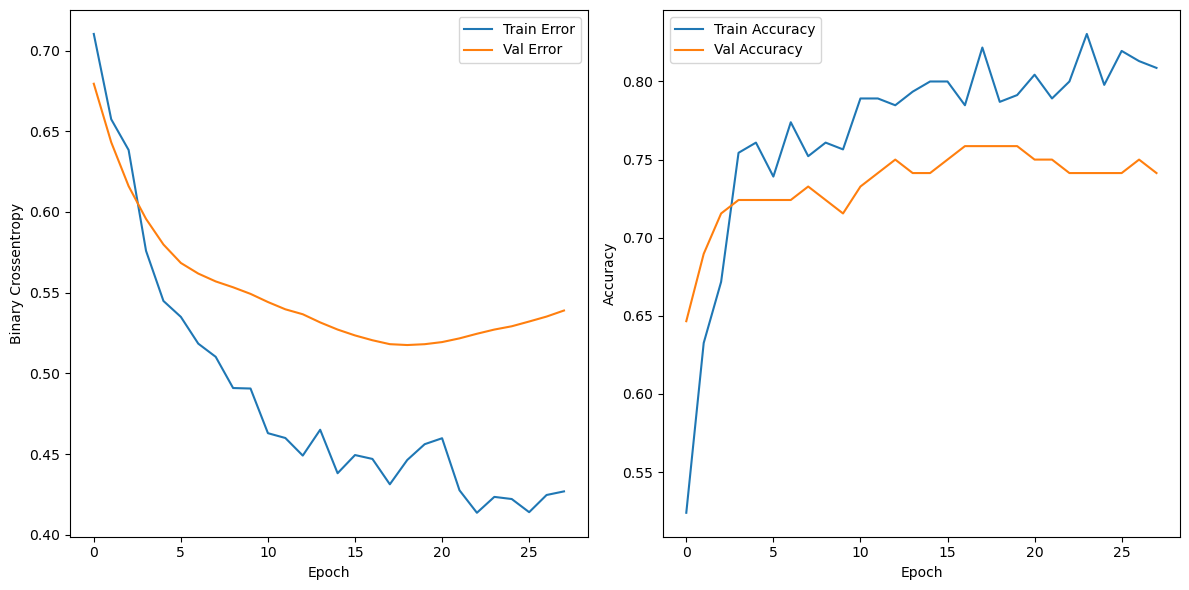

In [142]:
plot_history(final_history)

6/6 [==============================] - 0s 1ms/step


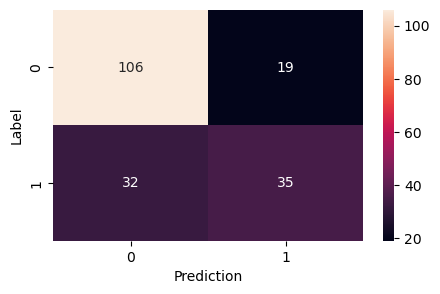

In [143]:
y_preds = final_model.predict(X_test)

confusion_mtx = plot_confusion_matrix(y_test, tf.round(y_preds),['0','1'],(5,3))

In [144]:
scores = final_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.5305 - accuracy: 0.7344


Our model is not very good, we should change it, but it's not the goal of this notebook.

<a name="7"></a>
## <font color='red'> 7. Making predictions </font> 

In [145]:
preds = final_model.predict(X_test)
preds[:3]

6/6 [==============================] - 0s 1ms/step


array([[0.09026575],
       [0.02197547],
       [0.4290681 ]], dtype=float32)

In [146]:
pred_classes = (preds > 0.5).astype(int)
pred_classes[:3]

array([[0],
       [0],
       [0]])

Now, let's make predictions with new data.

In [147]:
new_data = np.array([[7, 145, 70, 38, 1, 32.5, 0.6, 48]])

new_data_transformed = scaler.transform(new_data)
print(f"New data transformed: {new_data_transformed}")

New data transformed: [[ 0.95356327  0.72115243 -0.00174923  1.09914671 -0.70254292  0.05487398
   0.38942027  1.29710906]]


In [148]:
pred = final_model.predict(new_data_transformed)
pred

1/1 [==============================] - 0s 42ms/step


array([[0.8089405]], dtype=float32)

In [149]:
(pred > 0.5).astype(int)

array([[1]])